In [26]:
# -*- coding:utf-8 -*-


# general imports
import os.path as op
import os

# third party imports
import numpy as np
import nibabel as nib
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import json

require_labels = [0,    # background
                  1,    # spleen
                  2,    # right kidney
                  3,    # left kidney
                  6]    # liver

resample_size = [256,256,32]
# image_path = '../../Dataset/BTCV/data/'
save_path = '../../Dataset/BTCV/BTCV_%d_%d_%d/' % \
            (resample_size[0], resample_size[1], resample_size[2])
# process_list=['train', 'test']
labels, training, testing = None, None, None
with open("/root/autodl-tmp/abdomen/dataset_0.json", 'r', encoding='utf-') as f:
    content = f.read()
    jf = json.loads(content)
    labels, training, validating, testing = jf['labels'], jf['training'], jf['validation'], jf['test']


In [ ]:
import nibabel as nib
import dicom2nifti
import os
import matplotlib.image as mpimg
import numpy as np
from scipy.ndimage.interpolation import zoom

def read_nii( volume_path):
    nii = nib.load(volume_path)
    data = nii.get_fdata()
    header = nii.header
    affine = nii.affine
    spacing = list(nii.header['pixdim'][1:4])
    return data, header, affine, spacing

def save_nii(data, header, affine, path):
    new_nii = nib.Nifti1Image(data, affine.copy(), header.copy())
    nib.save(new_nii, path)
    
def resize(img, label, spacing, resample_size):
    assert img.shape == label.shape
    origin_shape = img.shape
    new_space = spacing * origin_shape / resample_size
    resize_factor = 1.0 * np.asarray(resample_size) / np.asarray(origin_shape)
    print('resize_factor: ', resize_factor)
    img = zoom(img, resize_factor, order=1) #order = 1：bilinear interpolaion
    label = zoom(label, resize_factor, order=0) #order = 0:nearest
    return img, label, new_space

def create_and_save_resize_data(resample_size, img, label,
                                spacing, img_header, img_affine, save_path):
    
    img, label, new_space = resize(img, label, np.array(spacing), resample_size)
    label = np.round(label)
    img_header['pixdim'][1:4] = new_space
    save_nii(img, img_header, img_affine, save_path+"procimg.nii")
    save_nii(label, img_header, img_affine, save_path+"proclabel.nii")
    return img, label
       
   
patients = os.listdir("/home/yijunl/segmentation/Train_Sets/MR/")
for patient in patients:
    if not os.path.exists("/home/yijunl/segmentation/Train_Sets/MR_new/"+patient):
        os.mkdir("/home/yijunl/segmentation/Train_Sets/MR_new/"+patient)
    print("/home/yijunl/segmentation/Train_Sets/MR/"+patient+"/T2SPIR/DICOM_anon/")
    dicom2nifti.dicom_series_to_nifti("/home/yijunl/segmentation/Train_Sets/MR/"+patient+"/T2SPIR/DICOM_anon/", "/home/yijunl/segmentation/Train_Sets/MR_new/"+patient+"/procimg.nii.gz")
   
    data, header, affine, spacing = read_nii("/home/yijunl/segmentation/Train_Sets/MR_new/"+patient+"/procimg.nii.gz")
    labels = os.listdir("/home/yijunl/segmentation/Train_Sets/MR/"+patient+"/T2SPIR/Ground/")

    label_list = mpimg.imread("/home/yijunl/segmentation/Train_Sets/MR/"+patient+"/T2SPIR/Ground/"+labels[0])[..., np.newaxis]
    for img in labels[1: ]:
        img = np.flip(mpimg.imread("/home/yijunl/segmentation/Train_Sets/MR/"+patient+"/T2SPIR/Ground/"+img).T, axis=1)[..., np.newaxis]
        label_list = np.concatenate([label_list, img], axis=2)
        
    create_and_save_resize_data((256, 256, 32), data, label_list, spacing, header, affine, "/home/yijunl/segmentation/Train_Sets/MR_new/"+patient+"/")
    # save_nii(label_list, header, a, ffine, "/home/yijunl/segmentation/Train_Sets/MR_new/"+patient+"/proclabel.nii")

In [ ]:
# import pathlib
# import numpy as np
# import nibabel as nib

# import torch
# from torch.utils.data import Dataset

# from tools import *

# class SegDataset(Dataset):
#     '''
    
#     '''
    
#     def __init__(self, atlas_list, target_filename, path):
#         self.atlas_list = atlas_list
#         self.target_filename = target_filename
#         self.path = path
#         self.atlas_img_ct, self.atlas_img_mr, self.atlas_ct_meta, self.atlas_label_ct, self.atlas_label_mr = [], [], [], []
#         for atlas in atlas_list:
#             if atlas.split("_")[0] == "MR":
#                 atlas_img_path = pathlib.Path(self.path, "train", atlas, "image.npy")
#                 atlas_img = torch.Tensor(np.load(atlas_img_path)[np.newaxis, ...])
#                 atlas_img = normalize(atlas_img, "win_max")
#                 self.atlas_img_mr.append(atlas_img)
                
#                 atlas_label_path = pathlib.Path(self.path, atlas, "seg.npy")
#                 atlas_label = torch.Tensor(np.round(np.load(atlas_label_path)[np.newaxis, ...]))
#                 self.atlas_label_mr.append(atlas_label)
                
#             elif atlas.split("_")[0] == "CT":
#                 atlas_img_path = pathlib.Path(self.path, "train", atlas, "procimg.nii.gz")
#                 atlas_img, header, affine, spacing = read_nii(atlas_img_path)
#                 atlas_img = torch.Tensor(atlas_img[np.newaxis, ...])
#                 atlas_img = normalize(atlas_img, "win_max")
#                 self.atlas_img_ct.append(atlas_img)
                
import nibabel as nib
import dicom2nifti
import os
import matplotlib.image as mpimg
import numpy as np

def read_nii( volume_path):
    nii = nib.load(volume_path)
    data = nii.get_fdata()
    header = nii.header
    affine = nii.affine
    spacing = list(nii.header['pixdim'][1:4])
    return data, header, affine, spacing

def save_nii(data, header, affine, path):
    new_nii = nib.Nifti1Image(data, affine.copy(), header.copy())
    nib.save(new_nii, path)
       
   
nii_file = dicom2nifti.dicom_series_to_nifti("/home/yijunl/segmentation/Train_Sets/MR/1/T2SPIR/DICOM_anon/", "/home/yijunl/segmentation/procimg.nii.gz")
data, header, affine, spacing = read_nii("/home/yijunl/segmentation/procimg.nii.gz")
imgs = os.listdir("/home/yijunl/segmentation/Train_Sets/MR/1/T2SPIR/Ground")
print(imgs)
img_list = mpimg.imread('/home/yijunl/segmentation/Train_Sets/MR/1/T2SPIR/Ground/'+imgs[0])[..., np.newaxis]
for img in imgs[1: ]:
    img = np.flip(mpimg.imread('/home/yijunl/segmentation/Train_Sets/MR/1/T2SPIR/Ground/'+img).T, axis=1)[..., np.newaxis]
    img_list = np.concatenate([img_list, img], axis=2)
    
print(img_list.shape)
save_nii(img_list, header, affine, "./test.nii")
    



In [27]:
def read_nii( volume_path):
    nii = nib.load(volume_path)
    data = nii.get_fdata()
    header = nii.header
    affine = nii.affine
    spacing = list(nii.header['pixdim'][1:4])
    return data, header, affine, spacing

def create_path(pathlist):
    for path in pathlist:
        if not op.exists(path):
            os.makedirs(path)
            
def save_nii( data, save_path, header, affine):
    new_img = nib.Nifti1Image(data, affine, header)
    nib.save(new_img, save_path)

def resize(img, label, spacing, resample_size):
    assert img.shape == label.shape
    origin_shape = img.shape
    new_space = spacing * origin_shape / resample_size
    resize_factor = 1.0 * np.asarray(resample_size) / np.asarray(origin_shape)
    print('resize_factor: ', resize_factor)
    img = zoom(img, resize_factor, order=1) #order = 1：bilinear interpolaion
    label = zoom(label, resize_factor, order=0) #order = 0:nearest
    return img, label, new_space
         
def create_and_save_resize_data(resample_size, img, label, patient,
                                spacing,img_header, img_affine,save_path):
    nii_save_path = op.join(save_path, patient)
    create_path([nii_save_path])
    img, label, new_space = resize(img, label, np.array(spacing), resample_size)
    label = np.round(label)
    img_header['pixdim'][1:4] = new_space
    save_nii(img, op.join(nii_save_path, 'procimg.nii.gz'), img_header, img_affine)
    save_nii(label, op.join(nii_save_path, 'seg.nii.gz'), img_header, img_affine)
    return img, label

Image and label shape before resize:  (512, 512, 147) (512, 512, 147)
resize_factor:  [0.5        0.5        0.21768707]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


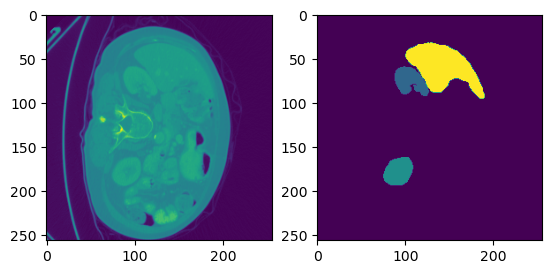


Image and label shape before resize:  (512, 512, 139) (512, 512, 139)
resize_factor:  [0.5        0.5        0.23021583]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


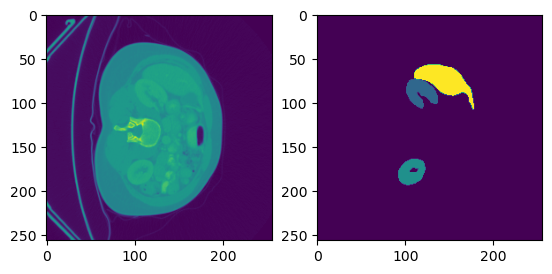


Image and label shape before resize:  (512, 512, 198) (512, 512, 198)
resize_factor:  [0.5        0.5        0.16161616]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


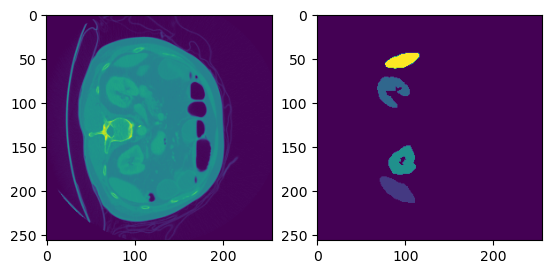


Image and label shape before resize:  (512, 512, 140) (512, 512, 140)
resize_factor:  [0.5        0.5        0.22857143]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


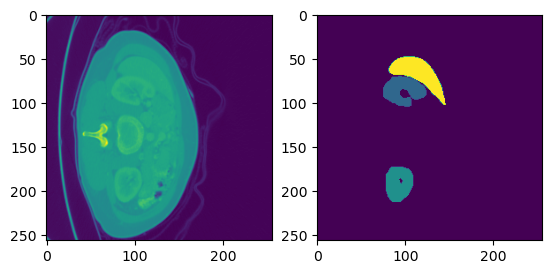


Image and label shape before resize:  (512, 512, 117) (512, 512, 117)
resize_factor:  [0.5        0.5        0.27350427]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


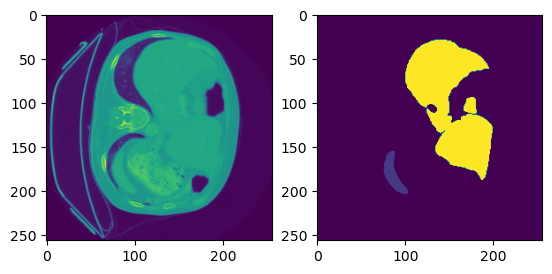


Image and label shape before resize:  (512, 512, 131) (512, 512, 131)
resize_factor:  [0.5        0.5        0.24427481]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


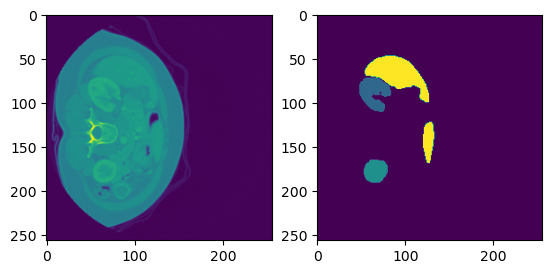


Image and label shape before resize:  (512, 512, 163) (512, 512, 163)
resize_factor:  [0.5        0.5        0.19631902]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


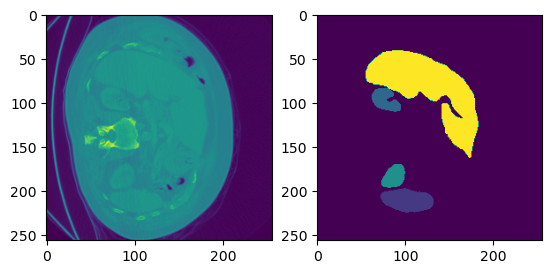


Image and label shape before resize:  (512, 512, 148) (512, 512, 148)
resize_factor:  [0.5        0.5        0.21621622]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


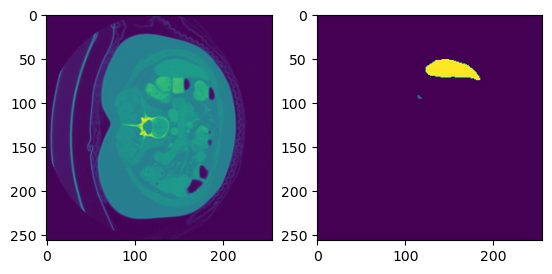


Image and label shape before resize:  (512, 512, 149) (512, 512, 149)
resize_factor:  [0.5       0.5       0.2147651]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


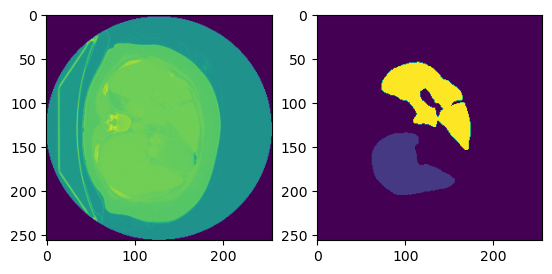


Image and label shape before resize:  (512, 512, 148) (512, 512, 148)
resize_factor:  [0.5        0.5        0.21621622]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


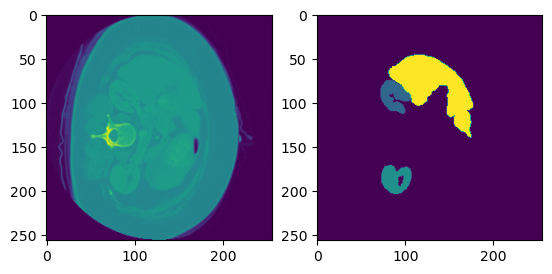


Image and label shape before resize:  (512, 512, 143) (512, 512, 143)
resize_factor:  [0.5        0.5        0.22377622]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


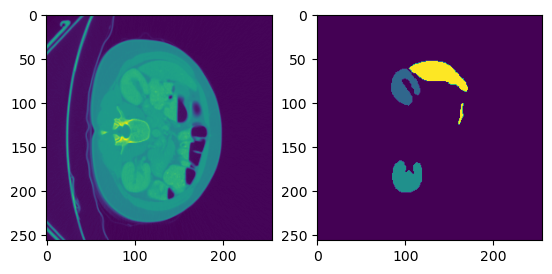


Image and label shape before resize:  (512, 512, 89) (512, 512, 89)
resize_factor:  [0.5        0.5        0.35955056]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


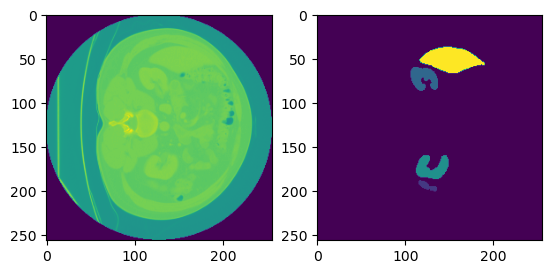


Image and label shape before resize:  (512, 512, 96) (512, 512, 96)
resize_factor:  [0.5        0.5        0.33333333]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


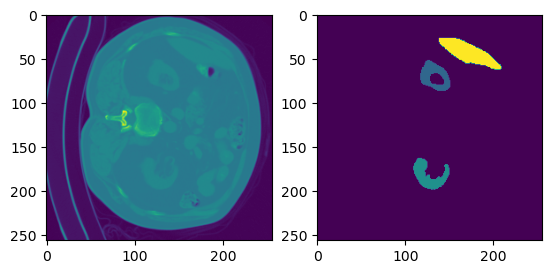


Image and label shape before resize:  (512, 512, 124) (512, 512, 124)
resize_factor:  [0.5        0.5        0.25806452]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


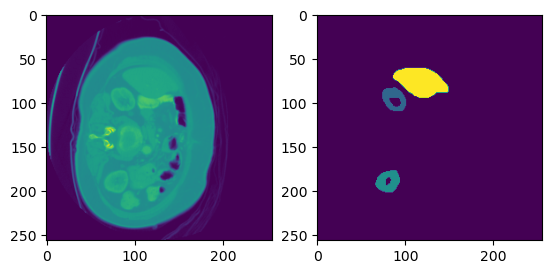


Image and label shape before resize:  (512, 512, 85) (512, 512, 85)
resize_factor:  [0.5        0.5        0.37647059]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


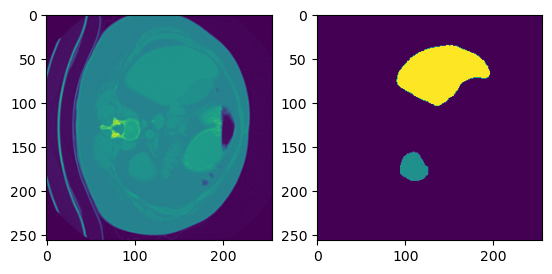


Image and label shape before resize:  (512, 512, 131) (512, 512, 131)
resize_factor:  [0.5        0.5        0.24427481]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


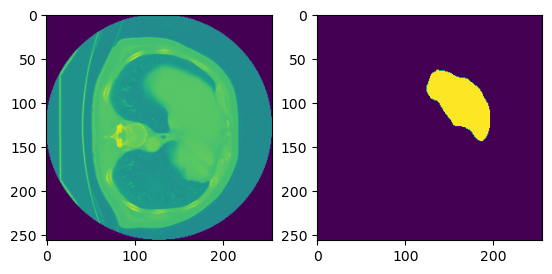


Image and label shape before resize:  (512, 512, 88) (512, 512, 88)
resize_factor:  [0.5        0.5        0.36363636]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


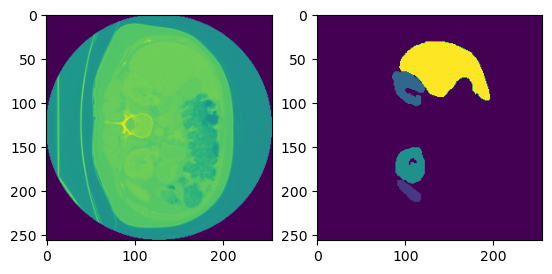


Image and label shape before resize:  (512, 512, 89) (512, 512, 89)
resize_factor:  [0.5        0.5        0.35955056]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


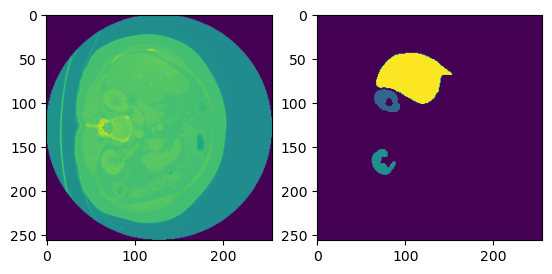


Image and label shape before resize:  (512, 512, 100) (512, 512, 100)
resize_factor:  [0.5  0.5  0.32]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


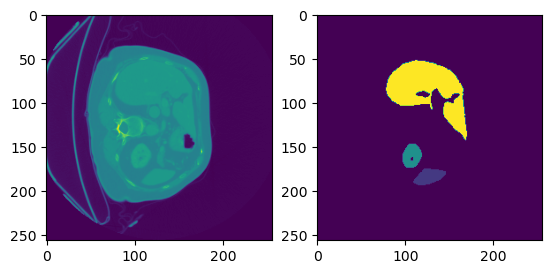


Image and label shape before resize:  (512, 512, 153) (512, 512, 153)
resize_factor:  [0.5        0.5        0.20915033]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


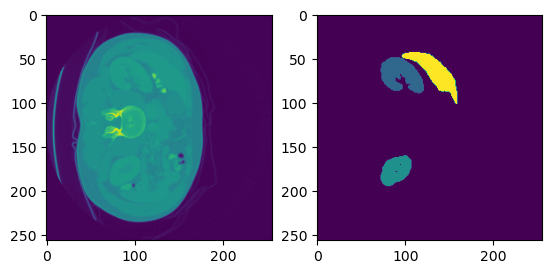


Image and label shape before resize:  (512, 512, 93) (512, 512, 93)
resize_factor:  [0.5        0.5        0.34408602]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


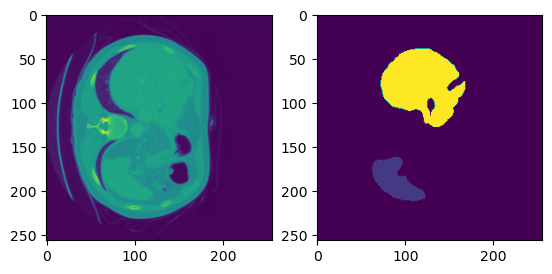


Image and label shape before resize:  (512, 512, 144) (512, 512, 144)
resize_factor:  [0.5        0.5        0.22222222]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


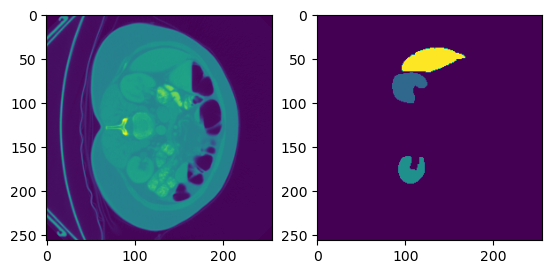


Image and label shape before resize:  (512, 512, 104) (512, 512, 104)
resize_factor:  [0.5        0.5        0.30769231]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


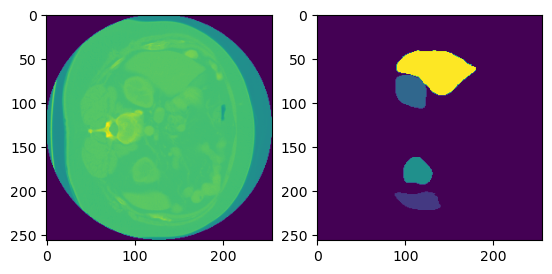


Image and label shape before resize:  (512, 512, 98) (512, 512, 98)
resize_factor:  [0.5        0.5        0.32653061]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


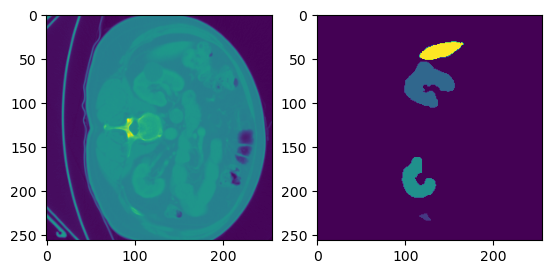


Image and label shape before resize:  (512, 512, 94) (512, 512, 94)
resize_factor:  [0.5        0.5        0.34042553]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


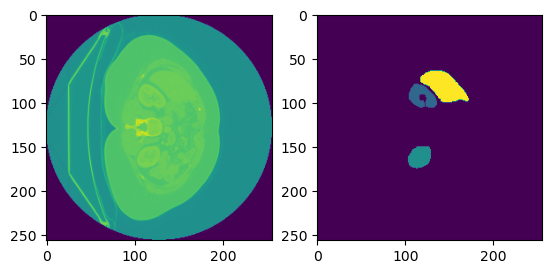


Image and label shape before resize:  (512, 512, 184) (512, 512, 184)
resize_factor:  [0.5        0.5        0.17391304]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


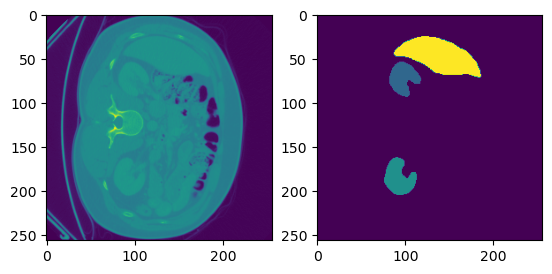


Image and label shape before resize:  (512, 512, 99) (512, 512, 99)
resize_factor:  [0.5        0.5        0.32323232]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


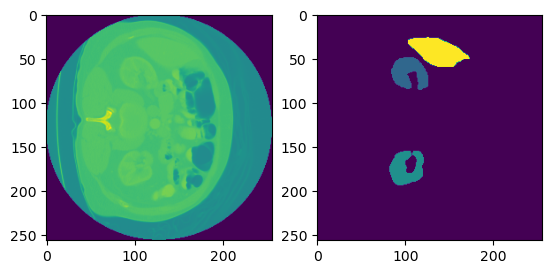


Image and label shape before resize:  (512, 512, 100) (512, 512, 100)
resize_factor:  [0.5  0.5  0.32]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


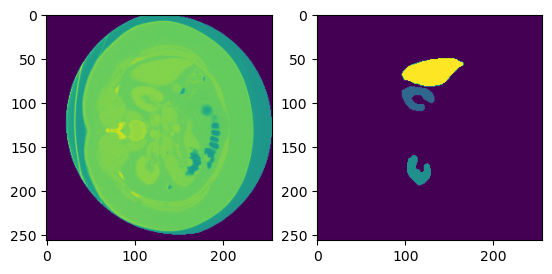


Image and label shape before resize:  (512, 512, 90) (512, 512, 90)
resize_factor:  [0.5        0.5        0.35555556]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


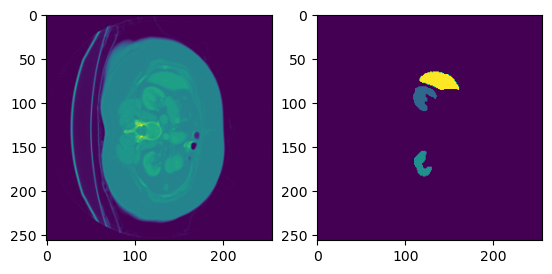


Image and label shape before resize:  (512, 512, 195) (512, 512, 195)
resize_factor:  [0.5        0.5        0.16410256]
Image and label shape after resize:  (256, 256, 32) (256, 256, 32)


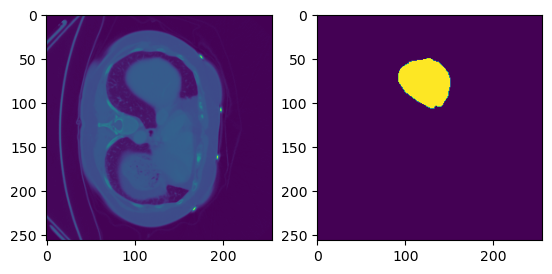

In [28]:
# for patient in range(44,91): 
    
#     print("Proprecess train image " + str(patient))
#     img, img_header, img_affine, img_spacing = read_nii(
#         op.join(image_path, 'image_'+str(patient)+'.nii.gz'))
#     label, label_header, label_affine, label_spacing = read_nii(
#         op.join(image_path, 'label_'+str(patient)+'.nii.gz'))
    # print('Image and label shape before resize: ', img.shape, label.shape)
    # print(img_spacing)
    # print(label.dtype)
#     #affine:voxel position to position in reference space

    # label_unique = np.unique(label)
    # label_unique = np.delete(label_unique, np.where(label_unique == 0))
    # print(label_unique)
    # print(len(label_unique))
    # for l in label_unique:
    #     if l not in require_labels:
    #         label[label == l] = 0 

#     if patient-43 in (6, 7, 9, 12, 15, 17, 21, 22, 28, 30): # Random selection validation set
#         save_path_ = save_path + '/valid/'
#     else :
#         save_path_ = save_path + '/train/'
    # img, label = create_and_save_resize_data(resample_size, img, label,
    #                                               patient, img_spacing,img_header, 
    #                                               img_affine, save_path_)
    
    # print('Image and label shape after resize: ', img.shape, label.shape)
    # fig,axes = plt.subplots(1,2)
    # ax1 = axes[0]
    # ax2 = axes[1]

    # ax1.imshow(img[:,:,20])
    # ax2.imshow(label[:,:,20])
    # plt.show()
    # print()
for patient in training:
    img, img_header, img_affine, img_spacing = read_nii(
        op.join("/root/autodl-tmp/abdomen/", patient['image']))
    label, label_header, label_affine, label_spacing = read_nii(
        op.join("/root/autodl-tmp/abdomen/", patient['label']))
    print('Image and label shape before resize: ', img.shape, label.shape)
    label_unique = np.unique(label)
    label_unique = np.delete(label_unique, np.where(label_unique == 0))

    for l in label_unique:
        if l not in require_labels:
            label[label == l] = 0 
            
    save_path_ = save_path + '/train/'
            
    img, label = create_and_save_resize_data(resample_size, img, label,
                                                patient['image'], img_spacing,img_header, 
                                                img_affine, save_path_)
    print('Image and label shape after resize: ', img.shape, label.shape)
    fig,axes = plt.subplots(1,2)
    ax1 = axes[0]
    ax2 = axes[1]

    ax1.imshow(img[:,:,20])
    ax2.imshow(label[:,:,20])
    plt.show()
    print()
    
for patient in validating:
    img, img_header, img_affine, img_spacing = read_nii(
        op.join("/root/autodl-tmp/abdomen/", patient['image']))
    label, label_header, label_affine, label_spacing = read_nii(
        op.join("/root/autodl-tmp/abdomen/", patient['label']))
    print('Image and label shape before resize: ', img.shape, label.shape)
    label_unique = np.unique(label)
    label_unique = np.delete(label_unique, np.where(label_unique == 0))

    for l in label_unique:
        if l not in require_labels:
            label[label == l] = 0 
            
    save_path_ = save_path + '/valid/'
            
    img, label = create_and_save_resize_data(resample_size, img, label,
                                                patient['image'], img_spacing,img_header, 
                                                img_affine, save_path_)
    print('Image and label shape after resize: ', img.shape, label.shape)
    fig,axes = plt.subplots(1,2)
    ax1 = axes[0]
    ax2 = axes[1]

    ax1.imshow(img[:,:,20])
    ax2.imshow(label[:,:,20])
    plt.show()
    print()
    
    
    